In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score , silhouette_score, davies_bouldin_score
from clustering_metrics import calculate_davies_bouldin_index, calculate_dunn_index, calculate_silhouette_score
from clustering_utils import euclidean_distance, manhattan_distance
from sklearn.cluster import AgglomerativeClustering
from typing import List, Tuple, Union, Dict


In [28]:
class My_AgglomerativeClustering:
    def __init__(self, n_clusters: int, linkage: str):
        self.n_clusters = n_clusters
        self.linkage = linkage
        if linkage == 'single':
            self.linkage_fn = self._single_linkage
        elif linkage == 'complete':
            self.linkage_fn = self._complete_linkage
        elif linkage == 'average':
            self.linkage_fn = self._average_linkage
        elif linkage == 'median':
            self.linkage_fn = self._median_linkage
        elif linkage == 'centroid':
            self.linkage_fn = self._centroid_linkage
        else:
            raise ValueError(f"Unknown linkage: {linkage}")

    def calculate_initial_distance_matrix(self, X: np.ndarray) -> np.ndarray:
        distances = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(i+1, X.shape[0]):
                distances[i, j] = euclidean_distance(X[i], X[j])
                distances[j, i] = distances[i, j]
        self.original_distances = distances.copy()
        return distances

    def fit(self, X: np.ndarray):
        self.X = X
        self.distances = self.calculate_initial_distance_matrix(X)
        self.clusters = [[i] for i in range(X.shape[0])]
        self.cluster_labels = np.arange(X.shape[0], dtype=int)
        while len(self.clusters) > self.n_clusters:
            closest_pair = self._find_closest_pair()
            self._merge_clusters(closest_pair)

        self.cluster_labels = self._clean_labels(self.cluster_labels)
        return self.cluster_labels

    def _clean_labels(self, labels: np.ndarray) -> np.ndarray:
        unique_labels = np.sort(np.unique(labels))
        for i, label in enumerate(unique_labels):
            labels[labels == label] = i
        return labels
    
    def _find_closest_pair(self) -> Tuple[int, int]:
        min_distance = float('inf')
        closest_pair = (-1, -1)
        for i, cluster in enumerate(self.clusters):
            for j, other_cluster in enumerate(self.clusters):
                if i>=j:
                    continue
                distance = self.linkage_fn(cluster, other_cluster, self.original_distances)
                if distance < min_distance:
                    min_distance = distance
                    closest_pair = (i, j)
        return closest_pair
    
    def _merge_clusters(self, closest_pair: Tuple[int,int]):
        cluster1 = self.clusters[closest_pair[0]]
        cluster2 = self.clusters[closest_pair[1]]
        self.clusters.remove(cluster1)
        self.clusters.remove(cluster2)
        new_cluster = cluster1 + cluster2
        self.clusters.append(new_cluster)
        for idx in new_cluster:
            self.cluster_labels[idx] = len(self.clusters) - 1

    def _single_linkage(self, cluster1: List[int], cluster2: List[int], distances: np.ndarray) -> float:
        return np.min([distances[i, j] for i in cluster1 for j in cluster2])
    
    def _complete_linkage(self, cluster1: List[int], cluster2: List[int], distances: np.ndarray) -> float:
        return np.max([distances[i, j] for i in cluster1 for j in cluster2])
    
    def _average_linkage(self, cluster1: List[int], cluster2: List[int], distances: np.ndarray) -> float:
        return np.mean([distances[i, j] for i in cluster1 for j in cluster2])
    
    def _median_linkage(self, cluster1: List[int], cluster2: List[int], distances: np.ndarray) -> float:
        return np.median([distances[i, j] for i in cluster1 for j in cluster2])
    
    def _centroid_linkage(self, cluster1: List[int], cluster2: List[int], distances: np.ndarray) -> float:
        cluster1_points = self.X[cluster1]
        cluster2_points = self.X[cluster2]
        centroid1 = np.mean(cluster1_points, axis=0)
        centroid2 = np.mean(cluster2_points, axis=0)
        return euclidean_distance(centroid1, centroid2)
    


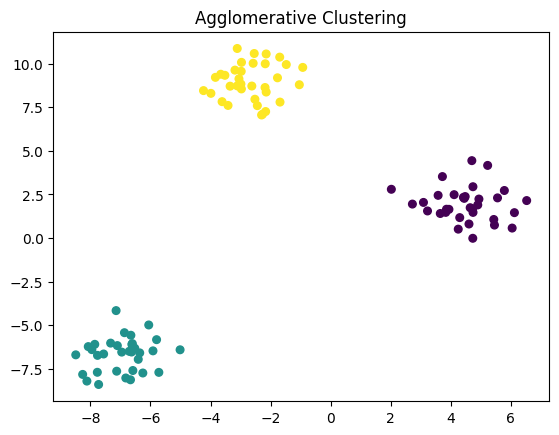

In [29]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic dataset
X, _ = make_blobs(n_samples=100, centers=3, random_state=42)

# Test Agglomerative Clustering
model = My_AgglomerativeClustering(n_clusters=3, linkage='single')
labels = model.fit(X)

# Visualize Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Agglomerative Clustering")
plt.show()


Labels (Custom): [1 0 2 0 1 0 2 0 0 2 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 2 0 1 1 1 1 0 0 1 2 2 2
 2 0 0 1 2 0 2 2 0 1 1 1 0 0 0 2 1 1 1 2 2 0 2 1 0 1 0 1 1 0 1 0 0 0 1 1 2
 0 1 0 1 0 0 2 0 2 1 2 2 2 0 2 0 0 0 2 0 2 2 2 0 1 2]
Labels (Sklearn): [1 0 2 0 1 0 2 0 0 2 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 2 0 1 1 1 1 0 0 1 2 2 2
 2 0 0 1 2 0 2 2 0 1 1 1 0 0 0 2 1 1 1 2 2 0 2 1 0 1 0 1 1 0 1 0 0 0 1 1 2
 0 1 0 1 0 0 2 0 2 1 2 2 2 0 2 0 0 0 2 0 2 2 2 0 1 2]
Are Labels Same? True


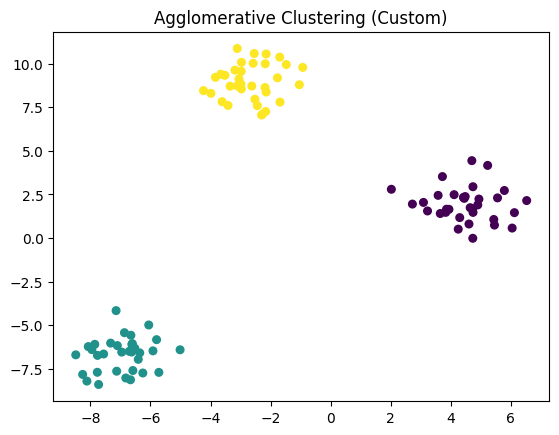

In [30]:
from sklearn.cluster import AgglomerativeClustering as SklearnAgglomerativeClustering

# Compare with sklearn implementation
sklearn_model = SklearnAgglomerativeClustering(n_clusters=3, linkage='single')
sklearn_labels = sklearn_model.fit_predict(X)

print("Labels (Custom):", labels)
print("Labels (Sklearn):", sklearn_labels)
print("Are Labels Same?", np.allclose(labels, sklearn_labels))
# plot 
plt.scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap='viridis', s=30)
plt.title("Agglomerative Clustering (Custom)")
plt.show()
